<a href="https://colab.research.google.com/github/abhranil-datascience/StockPricePrediction/blob/master/LSTM_StockPricePrediction_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
############################## Mount Drive ######################################## 
from google.colab import drive
drive.mount('/content/gdrive')
############################## Change Directory ###################################
import os
os.chdir('/content/gdrive/My Drive/StockPricePrediction')
########## Suppress Warnings ############
import warnings
warnings.filterwarnings('ignore')
########## Import Dataset ############
import pandas as pd
import numpy as np

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
################################################################# Read Stock Price Dataset ################################################################
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
import datetime
start_sp = datetime.datetime(2014, 12, 11)
end_sp = datetime.datetime(2019, 12, 11)
AppleDF = pdr.get_data_yahoo('AAPL',start_sp,end_sp)
AppleDF_Close_Price=AppleDF[['Close']]
AppleDF_Close_Price.reset_index(drop=True,inplace=True)
MicrosoftDF = pdr.get_data_yahoo('MSFT',start_sp,end_sp)
MicrosoftDF_Close_Price=MicrosoftDF[['Close']]
MicrosoftDF_Close_Price.reset_index(drop=True,inplace=True)
GoogleDF = pdr.get_data_yahoo('GOOG',start_sp,end_sp)
GoogleDF_Close_Price=GoogleDF[['Close']]
GoogleDF_Close_Price.reset_index(drop=True,inplace=True)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


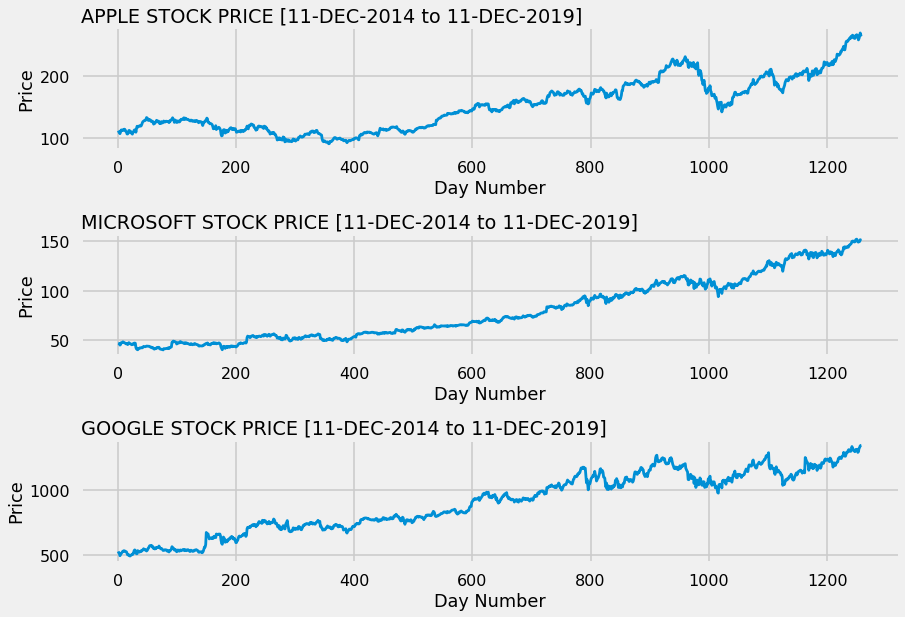

In [31]:
########################################################### View Dataset Closing Price Line Plots #########################################################################
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
fig = plt.figure()
plt.subplot(3, 1, 1)
plt.plot(range(1,len(AppleDF_Close_Price)+1),AppleDF_Close_Price)
plt.xlabel('Day Number')
plt.ylabel('Price')
plt.title('APPLE STOCK PRICE [11-DEC-2014 to 11-DEC-2019]',loc='left')
plt.subplot(3, 1, 2)
plt.plot(range(1,len(MicrosoftDF_Close_Price)+1),MicrosoftDF_Close_Price)
plt.xlabel('Day Number')
plt.ylabel('Price')
plt.title('MICROSOFT STOCK PRICE [11-DEC-2014 to 11-DEC-2019]',loc='left')
plt.subplot(3, 1, 3)
plt.plot(range(1,len(GoogleDF_Close_Price)+1),GoogleDF_Close_Price)
plt.xlabel('Day Number')
plt.ylabel('Price')
plt.title('GOOGLE STOCK PRICE [11-DEC-2014 to 11-DEC-2019]',loc='left')
plt.tight_layout()
plt.show()

In [5]:
#################################################### Train Test Seperation ###################################################################

########################################################## Google ############################################################################

NumberOfRows=GoogleDF_Close_Price.shape[0]
RowsToTest=NumberOfRows-30
GoogleDF_Train_Rows=GoogleDF_Close_Price[0:RowsToTest]
GoogleDF_Test_Rows=GoogleDF_Close_Price[RowsToTest:]
####### Take Last 100 Train data and append it before Test data ######
Last_hundred_train_data=GoogleDF_Train_Rows[(GoogleDF_Train_Rows.shape[0]-10):(GoogleDF_Train_Rows.shape[0])]
GoogleDF_Test_Rows=Last_hundred_train_data.append(GoogleDF_Test_Rows)
print(str(GoogleDF_Train_Rows.shape[0])+" || "+str(GoogleDF_Test_Rows.shape[0]))

########################################################## Microsoft ############################################################################
NumberOfRows=MicrosoftDF_Close_Price.shape[0]
RowsToTest=NumberOfRows-30
MicrosoftDF_Train_Rows=MicrosoftDF_Close_Price[0:RowsToTest]
MicrosoftDF_Test_Rows=MicrosoftDF_Close_Price[RowsToTest:]
####### Take Last 100 Train data and append it before Test data ######
Last_hundred_train_data=MicrosoftDF_Train_Rows[(MicrosoftDF_Train_Rows.shape[0]-10):(MicrosoftDF_Train_Rows.shape[0])]
MicrosoftDF_Test_Rows=Last_hundred_train_data.append(MicrosoftDF_Test_Rows)
print(str(MicrosoftDF_Train_Rows.shape[0])+" || "+str(MicrosoftDF_Test_Rows.shape[0]))

########################################################## Apple ############################################################################
NumberOfRows=AppleDF_Close_Price.shape[0]
RowsToTest=NumberOfRows-30
AppleDF_Train_Rows=AppleDF_Close_Price[0:RowsToTest]
AppleDF_Test_Rows=AppleDF_Close_Price[RowsToTest:]
####### Take Last 100 Train data and append it before Test data ######
Last_hundred_train_data=AppleDF_Train_Rows[(AppleDF_Train_Rows.shape[0]-10):(AppleDF_Train_Rows.shape[0])]
AppleDF_Test_Rows=Last_hundred_train_data.append(AppleDF_Test_Rows)
print(str(AppleDF_Train_Rows.shape[0])+" || "+str(AppleDF_Test_Rows.shape[0]))

1228 || 40
1228 || 40
1228 || 40


In [6]:
################################################ Function To arrange Stock Value in 100 TimeSteps ######################################################################
def ArrangeTimesteps(CurrDF):
  #print(str(CurrDF.shape))
  max_num_of_rows=CurrDF.shape[0]
  #print(str(max_num_of_rows))
  rows_to_train=max_num_of_rows-10
  #print(str(rows_to_train))
  XTrain=[]
  YTrain=[]
  for row_num in range(0,rows_to_train): 
    XTrainTemp=[]
    for var in range(0,10):
      if var==9:
        YTrain.append((CurrDF.iloc[row_num+var+1])['Close'])
      XTrainTemp.append((CurrDF.iloc[row_num+var])['Close'])
    XTrain.append(XTrainTemp)
  return [XTrain,YTrain]
################ Apple ##############################
AppleDFTrainSegmented=ArrangeTimesteps(AppleDF_Train_Rows)
AppleDF_XTrain=AppleDFTrainSegmented[0]
AppleDF_YTrain=AppleDFTrainSegmented[1]
AppleDFTestSegmented=ArrangeTimesteps(AppleDF_Test_Rows)
AppleDF_XTest=AppleDFTestSegmented[0]
AppleDF_YTest=AppleDFTestSegmented[1]
############## Microsoft ############################
MicrosoftDFTrainSegmented=ArrangeTimesteps(MicrosoftDF_Train_Rows)
MicrosoftDF_XTrain=MicrosoftDFTrainSegmented[0]
MicrosoftDF_YTrain=MicrosoftDFTrainSegmented[1]
MicrosoftDFTestSegmented=ArrangeTimesteps(MicrosoftDF_Test_Rows)
MicrosoftDF_XTest=MicrosoftDFTestSegmented[0]
MicrosoftDF_YTest=MicrosoftDFTestSegmented[1]
################ Google #############################
GoogleDFTrainSegmented=ArrangeTimesteps(GoogleDF_Train_Rows)
GoogleDF_XTrain=GoogleDFTrainSegmented[0]
GoogleDF_YTrain=GoogleDFTrainSegmented[1]
GoogleDFTestSegmented=ArrangeTimesteps(GoogleDF_Test_Rows)
GoogleDF_XTest=GoogleDFTestSegmented[0]
GoogleDF_YTest=GoogleDFTestSegmented[1]
print("Number Of Rows in Apple XTrain: "+str(len(AppleDF_XTrain))+" || Number Of Rows in Apple YTrain: "+str(len(AppleDF_YTrain)))
print("Number Of Rows in Apple XTest: "+str(len(AppleDF_XTest))+" || Number Of Rows in Apple YTest: "+str(len(AppleDF_YTest)))
print("Number Of Rows in Microsoft XTrain: "+str(len(MicrosoftDF_XTrain))+" || Number Of Rows in Microsoft YTrain: "+str(len(MicrosoftDF_YTrain)))
print("Number Of Rows in Microsoft XTest: "+str(len(MicrosoftDF_XTest))+" || Number Of Rows in Microsoft YTest: "+str(len(MicrosoftDF_YTest)))
print("Number Of Rows in Google XTrain: "+str(len(GoogleDF_XTrain))+" || Number Of Rows in Google YTrain: "+str(len(GoogleDF_YTrain)))
print("Number Of Rows in Google XTest: "+str(len(GoogleDF_XTest))+" || Number Of Rows in Google YTest: "+str(len(GoogleDF_YTest)))

Number Of Rows in Apple XTrain: 1218 || Number Of Rows in Apple YTrain: 1218
Number Of Rows in Apple XTest: 30 || Number Of Rows in Apple YTest: 30
Number Of Rows in Microsoft XTrain: 1218 || Number Of Rows in Microsoft YTrain: 1218
Number Of Rows in Microsoft XTest: 30 || Number Of Rows in Microsoft YTest: 30
Number Of Rows in Google XTrain: 1218 || Number Of Rows in Google YTrain: 1218
Number Of Rows in Google XTest: 30 || Number Of Rows in Google YTest: 30


In [0]:
########################################################### convert List to Array ######################################################################

########### Apple ####################
AppleXtrain=np.asarray(AppleDF_XTrain)
AppleYTrain=np.asarray(AppleDF_YTrain)
AppleXTest=np.asarray(AppleDF_XTest)
AppleYTest=np.asarray(AppleDF_YTest)

######### Microsoft ##################
MicrosoftXtrain=np.asarray(MicrosoftDF_XTrain)
MicrosoftYTrain=np.asarray(MicrosoftDF_YTrain)
MicrosoftXTest=np.asarray(MicrosoftDF_XTest)
MicrosoftYTest=np.asarray(MicrosoftDF_YTest)

############ Google ###################
GoogleXtrain=np.asarray(GoogleDF_XTrain)
GoogleYTrain=np.asarray(GoogleDF_YTrain)
GoogleXTest=np.asarray(GoogleDF_XTest)
GoogleYTest=np.asarray(GoogleDF_YTest)

In [8]:
################################################### Data Scaling ###################################################################
WholeDataDF=pd.concat((AppleDF_Close_Price,MicrosoftDF_Close_Price,GoogleDF_Close_Price),axis=0)
WholeDataArray=WholeDataDF.iloc[:,:].values
from sklearn.preprocessing import StandardScaler
DataScaler=StandardScaler()
DataScaler.fit(WholeDataArray)
AppleXtrainScaled=DataScaler.transform(AppleXtrain)
AppleYTrainScaled=DataScaler.transform(AppleYTrain.reshape(-1,1))
AppleXTestScaled=DataScaler.transform(AppleXTest)
AppleYTestScaled=DataScaler.transform(AppleYTest.reshape(-1,1))
MicrosoftXtrainScaled=DataScaler.transform(MicrosoftXtrain)
MicrosoftYTrainScaled=DataScaler.transform(MicrosoftYTrain.reshape(-1,1))
MicrosoftXTestScaled=DataScaler.transform(MicrosoftXTest)
MicrosoftYTestScaled=DataScaler.transform(MicrosoftYTest.reshape(-1,1))
GoogleXtrainScaled=DataScaler.transform(GoogleXtrain)
GoogleYTrainScaled=DataScaler.transform(GoogleYTrain.reshape(-1,1))
GoogleXTestScaled=DataScaler.transform(GoogleXTest)
GoogleYTestScaled=DataScaler.transform(GoogleYTest.reshape(-1,1))

print("Number Of Rows in Apple XTrain Scaled: "+str(AppleXtrainScaled.shape)+" || Number Of Rows in Apple YTrain Scaled: "+str(AppleYTrainScaled.shape[0]))
print("Number Of Rows in Apple XTest Scaled: "+str(AppleXTestScaled.shape)+" || Number Of Rows in Apple YTest Scaled: "+str(AppleYTestScaled.shape[0]))
print("Number Of Rows in Microsoft XTrain Scaled: "+str(MicrosoftXtrainScaled.shape)+" || Number Of Rows in Microsoft YTrain Scaled: "+str(MicrosoftYTrainScaled.shape[0]))
print("Number Of Rows in Microsoft XTest Scaled: "+str(MicrosoftXTestScaled.shape)+" || Number Of Rows in Microsoft YTest Scaled: "+str(MicrosoftYTestScaled.shape[0]))
print("Number Of Rows in Google XTrain Scaled: "+str(GoogleXtrainScaled.shape)+" || Number Of Rows in Google YTrain Scaled: "+str(GoogleYTrainScaled.shape[0]))
print("Number Of Rows in Google XTest Scaled: "+str(GoogleXTestScaled.shape)+" || Number Of Rows in Google YTest Scaled: "+str(GoogleYTestScaled.shape[0]))

Number Of Rows in Apple XTrain Scaled: (1218, 10) || Number Of Rows in Apple YTrain Scaled: 1218
Number Of Rows in Apple XTest Scaled: (30, 10) || Number Of Rows in Apple YTest Scaled: 30
Number Of Rows in Microsoft XTrain Scaled: (1218, 10) || Number Of Rows in Microsoft YTrain Scaled: 1218
Number Of Rows in Microsoft XTest Scaled: (30, 10) || Number Of Rows in Microsoft YTest Scaled: 30
Number Of Rows in Google XTrain Scaled: (1218, 10) || Number Of Rows in Google YTrain Scaled: 1218
Number Of Rows in Google XTest Scaled: (30, 10) || Number Of Rows in Google YTest Scaled: 30


In [0]:
########################################################### Apple LSTM ##########################################################################
AppleBestModelFilepath='/content/gdrive/My Drive/StockPricePrediction/AppleBestModel/AppleBestLSTMModel.h5'
from keras.models import Sequential,load_model
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
save_best_model_apple=ModelCheckpoint(AppleBestModelFilepath, monitor='mean_absolute_error', verbose=1, save_best_only=True, mode='min')
ReduceLR_apple=ReduceLROnPlateau(monitor='mean_absolute_error',factor=0.8,patience=5,verbose=2,cooldown=1, min_delta=0.0002, min_lr=0.,mode='min')
early_stop_apple=EarlyStopping(monitor='mean_absolute_error',min_delta=0.0020,patience=15,restore_best_weights=True,mode='min',verbose=2)
AppleXtrainScaledTimeAdjusted=AppleXtrainScaled.reshape(AppleXtrainScaled.shape[0],AppleXtrainScaled.shape[1],1)
######### Input Layer ##############
regressor_apple=Sequential()
########### Layer 1 ################
regressor_apple.add(LSTM(input_shape=(AppleXtrainScaledTimeAdjusted.shape[1],1),units=100,return_sequences=True))
regressor_apple.add(Dropout(0.2))
########### Layer 2 ################
regressor_apple.add(LSTM(units=50,return_sequences=True))
regressor_apple.add(Dropout(0.2))
########### Layer 3 ################
regressor_apple.add(LSTM(units=150,return_sequences=True))
regressor_apple.add(Dropout(0.2))
########### Layer 4 ################
regressor_apple.add(LSTM(units=50,return_sequences=False))
regressor_apple.add(Dropout(0.2))
########### Output Layer ###################
regressor_apple.add(Dense(units=1))
########### Compile Model ##################
regressor_apple.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae'])
########### Fitting the RNN ################
regressor_apple.fit(x=AppleXtrainScaledTimeAdjusted,y=AppleYTrainScaled,batch_size=4,epochs=50,callbacks=[save_best_model_apple,ReduceLR_apple,early_stop_apple])

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





1218/1218 [==============================] - 21s 17ms/step - loss: 0.0120 - mean_absolute_error: 0.0740

Epoch 00001: mean_absolute_error improved from inf to 0.07402, saving model to /content/gdrive/My Drive/StockPricePrediction/AppleBestModel/AppleBestLSTMModel.h5
Epoch 2/50
1218/1218 [==============================] - 19s 15ms/step - loss: 0.0039 - mean_absolute_error: 0.0495

Epoch 00002: mean_absolute_error improved from 0.07402 to 0.04947, saving model to /content/gdrive/My Drive/StockPricePrediction/AppleBestModel/AppleBestLSTMModel.h5
Epoch 3/50
1218/1218 [==============================] - 18s 15ms/step - loss: 0.0024 - mean_absolute_error: 0.0394

Epoch 00003: mean_absolute_error improved from 0.04947 to 0.03938, saving model to /content/gdrive/My 

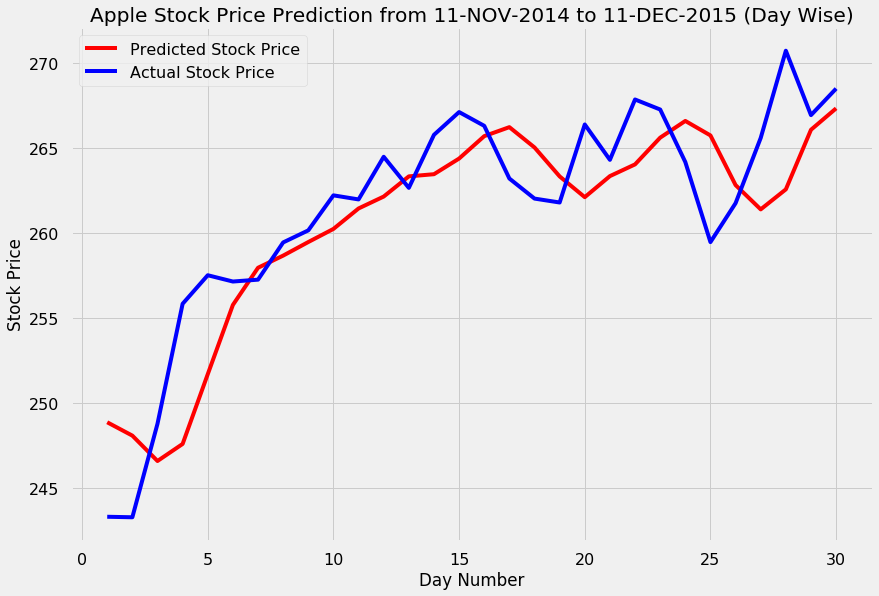

In [0]:
############################################### Apple Stock Prediction and Plot ######################################################################
BestRegressorApple=load_model(AppleBestModelFilepath)
AppleXtestScaledTimeAdjusted=AppleXTestScaled.reshape(AppleXTestScaled.shape[0],AppleXTestScaled.shape[1],1)
AppleTestPredScaled=BestRegressorApple.predict(AppleXtestScaledTimeAdjusted)
########## Plot Graph ############
AppleTestPred=DataScaler.inverse_transform(AppleTestPredScaled.reshape(-1,1))
AppleTestOriginal=DataScaler.inverse_transform(AppleYTestScaled.reshape(-1,1))
num_of_datapoints=AppleTestOriginal.shape[0]+1
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.plot(range(1,num_of_datapoints),AppleTestPred,c='red',label='Predicted Stock Price')
plt.plot(range(1,num_of_datapoints),AppleTestOriginal,c='blue',label='Actual Stock Price')
plt.legend()
plt.xlabel('Day Number')
plt.ylabel('Stock Price')
plt.title('Apple Stock Price Prediction from 11-NOV-2014 to 11-DEC-2015 (Day Wise)')
plt.show()

In [0]:
################################################ Mean Squared Error For Apple #############################################################
import sklearn.metrics as mt
print("Mean Squared Error For Apple Stock Price: "+str(mt.mean_squared_error(AppleTestOriginal,AppleTestPred)))
maxdiff_final=0
error_sum=0
for count in range(0,AppleTestPred.shape[0]):
  if AppleTestPred[count]>AppleTestOriginal[count]:
    max_diff=AppleTestPred[count]-AppleTestOriginal[count]
    error_sum=error_sum+max_diff
  else:
    max_diff=AppleTestOriginal[count]-AppleTestPred[count]
    error_sum=error_sum+max_diff
  if max_diff>maxdiff_final:
    maxdiff_final=max_diff
print("Max Difference between actual and Predicted Stock Price For Apple: "+str(maxdiff_final)+" units and average difference is "+str(error_sum/AppleTestOriginal.shape[0]))

Mean Squared Error For Apple Stock Price: 12.57224814903237
Max Difference between actual and Predicted Stock Price For Apple: [8.2454373] units and average difference is [2.79183807]


In [0]:
########################################################### Microsoft LSTM ##########################################################################
MicrosoftBestModelFilepath='/content/gdrive/My Drive/StockPricePrediction/MicrosoftBestModel/MicrosoftBestModel.h5'
from keras.models import Sequential,load_model
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
save_best_model_microsoft=ModelCheckpoint(MicrosoftBestModelFilepath, monitor='mean_absolute_error', verbose=1, save_best_only=True, mode='min')
ReduceLR_microsoft=ReduceLROnPlateau(monitor='mean_absolute_error',factor=0.8,patience=5,verbose=2,cooldown=1, min_delta=0.0020, min_lr=0.,mode='min')
early_stop_microsoft=EarlyStopping(monitor='mean_absolute_error',min_delta=0.0020,patience=15,restore_best_weights=True,mode='min',verbose=2)
MicrosoftXtrainScaledTimeAdjusted=MicrosoftXtrainScaled.reshape(MicrosoftXtrainScaled.shape[0],MicrosoftXtrainScaled.shape[1],1)
######### Input Layer ##############
regressor_microsoft=Sequential()
########### Layer 1 ################
regressor_microsoft.add(LSTM(input_shape=(MicrosoftXtrainScaledTimeAdjusted.shape[1],1),units=100,return_sequences=True))
regressor_microsoft.add(Dropout(0.2))
########### Layer 2 ################
regressor_microsoft.add(LSTM(units=50,return_sequences=True))
regressor_microsoft.add(Dropout(0.2))
########### Layer 3 ################
regressor_microsoft.add(LSTM(units=150,return_sequences=True))
regressor_microsoft.add(Dropout(0.2))
########### Layer 4 ################
regressor_microsoft.add(LSTM(units=50,return_sequences=False))
regressor_microsoft.add(Dropout(0.2))
########### Output Layer ###################
regressor_microsoft.add(Dense(units=1))
########### Compile Model ##################
regressor_microsoft.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae'])
########### Fitting the RNN ################
regressor_microsoft.fit(x=MicrosoftXtrainScaledTimeAdjusted,y=MicrosoftYTrainScaled,batch_size=4,epochs=50,callbacks=[save_best_model_microsoft,ReduceLR_microsoft,early_stop_microsoft])

Epoch 1/50
1218/1218 [==============================] - 23s 19ms/step - loss: 0.0168 - mean_absolute_error: 0.0853

Epoch 00001: mean_absolute_error improved from inf to 0.08530, saving model to /content/gdrive/My Drive/StockPricePrediction/MicrosoftBestModel/MicrosoftBestModel.h5
Epoch 2/50
1218/1218 [==============================] - 20s 16ms/step - loss: 0.0060 - mean_absolute_error: 0.0621

Epoch 00002: mean_absolute_error improved from 0.08530 to 0.06209, saving model to /content/gdrive/My Drive/StockPricePrediction/MicrosoftBestModel/MicrosoftBestModel.h5
Epoch 3/50
1218/1218 [==============================] - 20s 16ms/step - loss: 0.0043 - mean_absolute_error: 0.0516

Epoch 00003: mean_absolute_error improved from 0.06209 to 0.05163, saving model to /content/gdrive/My Drive/StockPricePrediction/MicrosoftBestModel/MicrosoftBestModel.h5
Epoch 4/50
1218/1218 [==============================] - 20s 16ms/step - loss: 0.0044 - mean_absolute_error: 0.0522

Epoch 00004: mean_absolute_err

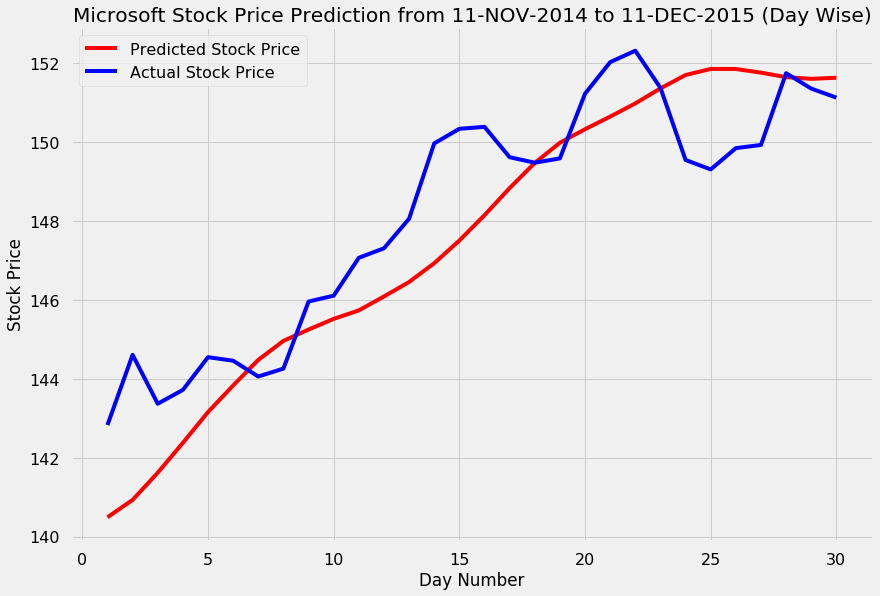

In [0]:
############################################### Microsoft Stock Prediction and Plot ######################################################################
BestRegressorMicrosoft=load_model(MicrosoftBestModelFilepath)
MicrosoftXtestScaledTimeAdjusted=MicrosoftXTestScaled.reshape(MicrosoftXTestScaled.shape[0],MicrosoftXTestScaled.shape[1],1)
MicrosoftTestPredScaled=BestRegressorMicrosoft.predict(MicrosoftXtestScaledTimeAdjusted)
########## Plot Graph ############
MicrosoftTestPred=DataScaler.inverse_transform(MicrosoftTestPredScaled.reshape(-1,1))
MicrosoftTestOriginal=DataScaler.inverse_transform(MicrosoftYTestScaled.reshape(-1,1))
num_of_datapoints=MicrosoftTestOriginal.shape[0]+1
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.plot(range(1,num_of_datapoints),MicrosoftTestPred,c='red',label='Predicted Stock Price')
plt.plot(range(1,num_of_datapoints),MicrosoftTestOriginal,c='blue',label='Actual Stock Price')
plt.legend()
plt.xlabel('Day Number')
plt.ylabel('Stock Price')
plt.title('Microsoft Stock Price Prediction from 11-NOV-2014 to 11-DEC-2015 (Day Wise)')
plt.show()

In [0]:
################################################ Mean Squared Error For Microsoft #############################################################
import sklearn.metrics as mt
print("Mean Squared Error For Microsoft Stock Price: "+str(mt.mean_squared_error(MicrosoftTestOriginal,MicrosoftTestPred)))
maxdiff_final=0
error_sum=0
for count in range(0,MicrosoftTestPred.shape[0]):
  if MicrosoftTestPred[count]>MicrosoftTestOriginal[count]:
    max_diff=MicrosoftTestPred[count]-MicrosoftTestOriginal[count]
    error_sum=error_sum+max_diff
  else:
    max_diff=MicrosoftTestOriginal[count]-MicrosoftTestPred[count]
    error_sum=error_sum+max_diff
  if max_diff>maxdiff_final:
    maxdiff_final=max_diff
print("Max Difference between actual and Predicted Stock Price: "+str(maxdiff_final)+" units and average difference is "+str(error_sum/MicrosoftTestOriginal.shape[0]))

Mean Squared Error For Microsoft Stock Price: 2.6651617104005494
Max Difference between actual and Predicted Stock Price: [3.67816201] units and average difference is [1.33451689]


In [23]:
########################################################### Google LSTM ##########################################################################
GoogleBestModelFilepath='/content/gdrive/My Drive/StockPricePrediction/GoogleBestModel/GoogleBestModel.h5'
from keras.models import Sequential,load_model
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.optimizers import Adam
save_best_model_google=ModelCheckpoint(GoogleBestModelFilepath, monitor='mean_absolute_error', verbose=1, save_best_only=True, mode='min')
ReduceLR_google=ReduceLROnPlateau(monitor='mean_absolute_error',factor=0.8,patience=5,verbose=2,cooldown=1, min_delta=0.0020, min_lr=0.,mode='min')
early_stop_google=EarlyStopping(monitor='mean_absolute_error',min_delta=0.0020,patience=15,restore_best_weights=True,mode='min',verbose=2)
GoogleXtrainScaledTimeAdjusted=GoogleXtrainScaled.reshape(GoogleXtrainScaled.shape[0],GoogleXtrainScaled.shape[1],1)
######### Input Layer ##############
regressor_google=Sequential()
########### Layer 3 ################
regressor_google.add(LSTM(input_shape=(GoogleXtrainScaledTimeAdjusted.shape[1],1),units=100,return_sequences=True))
regressor_google.add(Dropout(0.2))
########### Layer 4 ################
regressor_google.add(LSTM(units=50,return_sequences=True))
regressor_google.add(Dropout(0.2))
"""
########### Layer 5 ################
regressor_google.add(LSTM(units=150,return_sequences=True))
regressor_google.add(Dropout(0.2))
"""
########### Layer 6 ################
regressor_google.add(LSTM(units=50,return_sequences=False))
regressor_google.add(Dropout(0.2))
########### Output Layer ###################
regressor_google.add(Dense(units=1))
########### Compile Model ##################
regressor_google.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae'])
########### Fitting the RNN ################
regressor_google.fit(x=GoogleXtrainScaledTimeAdjusted,y=GoogleYTrainScaled,batch_size=4,epochs=100,callbacks=[save_best_model_google,ReduceLR_google,early_stop_google])

Epoch 1/100
1218/1218 [==============================] - 22s 18ms/step - loss: 0.0872 - mean_absolute_error: 0.1849

Epoch 00001: mean_absolute_error improved from inf to 0.18487, saving model to /content/gdrive/My Drive/StockPricePrediction/GoogleBestModel/GoogleBestModel.h5
Epoch 2/100
1218/1218 [==============================] - 16s 13ms/step - loss: 0.0255 - mean_absolute_error: 0.1177

Epoch 00002: mean_absolute_error improved from 0.18487 to 0.11773, saving model to /content/gdrive/My Drive/StockPricePrediction/GoogleBestModel/GoogleBestModel.h5
Epoch 3/100
1218/1218 [==============================] - 15s 12ms/step - loss: 0.0253 - mean_absolute_error: 0.1194

Epoch 00003: mean_absolute_error did not improve from 0.11773
Epoch 4/100
1218/1218 [==============================] - 15s 13ms/step - loss: 0.0202 - mean_absolute_error: 0.1075

Epoch 00004: mean_absolute_error improved from 0.11773 to 0.10748, saving model to /content/gdrive/My Drive/StockPricePrediction/GoogleBestModel/G

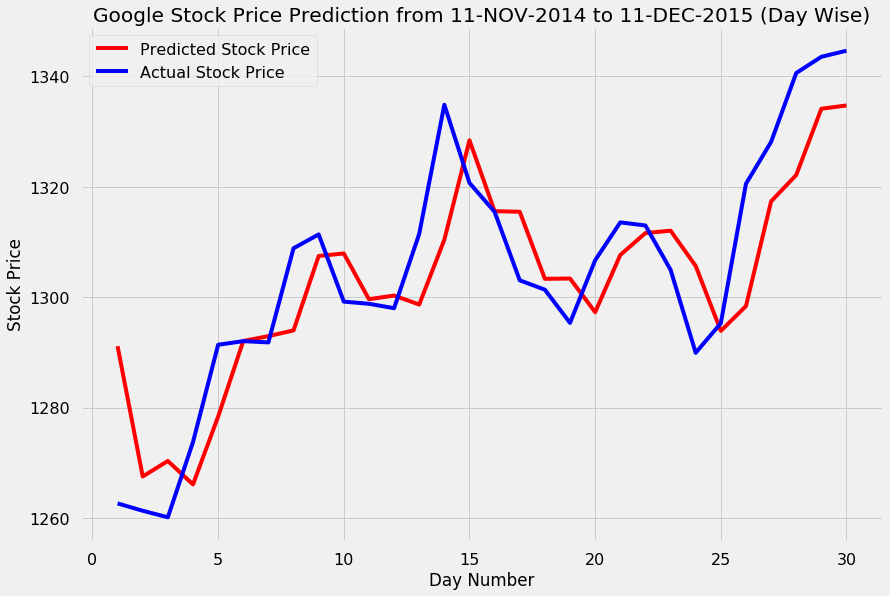

In [29]:
############################################### Google Stock Prediction and Plot ######################################################################
BestRegressorGoogle=load_model(GoogleBestModelFilepath)
GoogleXtestScaledTimeAdjusted=GoogleXTestScaled.reshape(GoogleXTestScaled.shape[0],GoogleXTestScaled.shape[1],1)
GoogleTestPredScaled=BestRegressorGoogle.predict(GoogleXtestScaledTimeAdjusted)
########## Plot Graph ############
GoogleTestPred=DataScaler.inverse_transform(GoogleTestPredScaled.reshape(-1,1))
GoogleTestOriginal=DataScaler.inverse_transform(GoogleYTestScaled.reshape(-1,1))
GoogleTestPred=GoogleTestPred+31
num_of_datapoints=GoogleTestOriginal.shape[0]+1
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.plot(range(1,num_of_datapoints),GoogleTestPred,c='red',label='Predicted Stock Price')
plt.plot(range(1,num_of_datapoints),GoogleTestOriginal,c='blue',label='Actual Stock Price')
plt.legend()
plt.xlabel('Day Number')
plt.ylabel('Stock Price')
plt.title('Google Stock Price Prediction from 11-NOV-2014 to 11-DEC-2015 (Day Wise)')
plt.show()

In [30]:
################################################ Mean Squared Error For Google #############################################################
import sklearn.metrics as mt
print("Mean Squared Error For Google Stock Price: "+str(mt.mean_squared_error(GoogleTestOriginal,GoogleTestPred)))
maxdiff_final=0
error_sum=0
for count in range(0,GoogleTestPred.shape[0]):
  if GoogleTestPred[count]>GoogleTestOriginal[count]:
    max_diff=GoogleTestPred[count]-GoogleTestOriginal[count]
    error_sum=error_sum+max_diff
  else:
    max_diff=GoogleTestOriginal[count]-GoogleTestPred[count]
    error_sum=error_sum+max_diff
  if max_diff>maxdiff_final:
    maxdiff_final=max_diff
print("Max Difference between actual and Predicted Stock Price: "+str(maxdiff_final)+" units and average difference is "+str(error_sum/GoogleTestOriginal.shape[0]))

Mean Squared Error For Google Stock Price: 136.95784656930527
Max Difference between actual and Predicted Stock Price: [28.49426281] units and average difference is [9.22000728]
